<a href="https://colab.research.google.com/github/williamedwardhahn/ComplexSystems/blob/main/Complex_Systems_Lab_Pretrained_Folder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Two possible ways to create your dataset: (1) Make one with your own with your camera/phone or (2) Build one with Image Search (Google/Bing)

The idea is to have (at least) two categories for which you will train an inference model. You will then present data from your reserved validation set to evaluate your models ability to distinguish the two categories. For example, pick any living object like ants and then collect photos with and without ants in the pictures. You will then put these pictures on your google drive and run a classification model just like with flowers 102.

The more photos you collect the better your model will be. You must have at least 50 photographs for each of your two categories. (This should not take a long time.)

Note you must put around 20% of your images into the valid folder.

Example data folders here: https://drive.google.com/drive/folders/1Je_gRF8RnhszAAbQhw2IzqM2_7byPVtL?usp=sharing

Example Ideas:

Ex1 Camera: Ant finder Close up of ground/floor with ants in photo vs Close up photo with no ants

Ex2 Camera: Palm tree with coconuts vs Palm tree with dates (Both are all over FAU)

Ex3 Web Search: Marine animal (bird) vs Marine animal covered in oil from oil spill

Ex4 Web Search: Burrowing owl adult vs Burrowing owl chick

In [ ]:
!pip install flashtorch
!pip install barbar

In [ ]:
!pip install git+https://github.com/williamedwardhahn/mpcr
from mpcr import *
from flashtorch.utils import apply_transforms
from flashtorch.saliency import Backprop
import itertools
from sklearn.metrics import confusion_matrix

  Cloning https://github.com/williamedwardhahn/mpcr to /tmp/pip-req-build-0rk0sji4
  Running command git clone -q https://github.com/williamedwardhahn/mpcr /tmp/pip-req-build-0rk0sji4
  Created wheel for ImportMPCR: filename=ImportMPCR-0.0.1-cp36-none-any.whl size=7323 sha256=ed3925f8429a3f00f6e7d5906398fc84a1ee8bb238d4c0f2d6086ae987a0e5b6
  Stored in directory: /tmp/pip-ephem-wheel-cache-nbb_ch4c/wheels/89/93/47/ef43fe80a5b823a05d8dcca5ed1581f4fcdacf69b27110603f
Successfully built ImportMPCR
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Create new folder on your google drive like below:

In [ ]:
data_dir = '/content/drive/My Drive/Data1/antsbeesdataset/'

In [ ]:
os.chdir(data_dir)

In [ ]:
dataset_labels =["ants", "bees"] #<--- Replace with your labels 

In [ ]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  #Data Augmentation 
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [ ]:
batch_size = 16
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
dataset_sizes

{'train': 244, 'valid': 153}

In [ ]:
def imshow(inp, title = " "):
    fig, ax = plt.subplots()
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    ax.imshow(inp)
    plt.title(title, loc='center')
    # fig.set_size_inches(5, 5)
    plt.show()

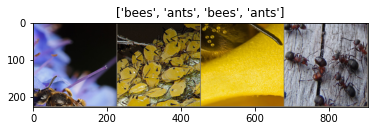

In [ ]:
inputs, classes = next(iter(dataloaders['train']))
inputs = inputs[:4]
classes = classes[:4] 
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[dataset_labels[x] for x in classes])

In [ ]:
def train_model(model, num_epochs=25):

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    for epoch in range(num_epochs):

        print('Epoch: ',epoch+1,'/',num_epochs)

        ###Train
        model.train() 
        running_corrects = 0
        for inputs, labels in dataloaders['train']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            preds = torch.max(outputs, 1)[1]
            running_corrects += torch.sum(preds == labels.data)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        print("Train ", 'Acc: {:.2f}'.format(running_corrects.double()/dataset_sizes['train']))
        
        scheduler.step()
    
        ###Val
        model.eval()  
        running_corrects = 0
        for inputs, labels in dataloaders['valid']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            preds = torch.max(outputs, 1)[1]
            running_corrects += torch.sum(preds == labels.data)

        print("Valid ", 'Acc: {:.2f}'.format(running_corrects.double()/dataset_sizes['valid']))
        print("#######################")
    return model

In [ ]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 102)

In [ ]:
model = train_model(model, num_epochs=30)

Epoch:  1 / 30
Train  Acc: 0.49
Valid  Acc: 0.80
#######################
Epoch:  2 / 30
Train  Acc: 0.86
Valid  Acc: 0.94
#######################
Epoch:  3 / 30
Train  Acc: 0.91
Valid  Acc: 0.93
#######################
Epoch:  4 / 30
Train  Acc: 0.90
Valid  Acc: 0.94
#######################
Epoch:  5 / 30
Train  Acc: 0.93
Valid  Acc: 0.93
#######################
Epoch:  6 / 30
Train  Acc: 0.90
Valid  Acc: 0.95
#######################
Epoch:  7 / 30
Train  Acc: 0.92
Valid  Acc: 0.97
#######################
Epoch:  8 / 30
Train  Acc: 0.95
Valid  Acc: 0.93
#######################
Epoch:  9 / 30
Train  Acc: 0.94
Valid  Acc: 0.96
#######################
Epoch:  10 / 30
Train  Acc: 0.97
Valid  Acc: 0.96
#######################
Epoch:  11 / 30
Train  Acc: 0.96
Valid  Acc: 0.95
#######################
Epoch:  12 / 30
Train  Acc: 0.96
Valid  Acc: 0.96
#######################
Epoch:  13 / 30
Train  Acc: 0.94
Valid  Acc: 0.95
#######################
Epoch:  14 / 30
Train  Acc: 0.96
Valid  Acc: 0.

In [ ]:
def visualize_model(model, num_images=16):
    model.eval()
    index = 0
    for i, (inputs, labels) in enumerate(dataloaders['valid']):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        preds = torch.max(outputs, 1)[1]

        for j in range(inputs.size()[0]):
            index += 1
            title1 = 'predicted: ' + dataset_labels[preds[j]] + '     class: ' + dataset_labels[labels[j]]
            imshow(inputs.cpu().data[j],title1)

            if index == num_images:
                return

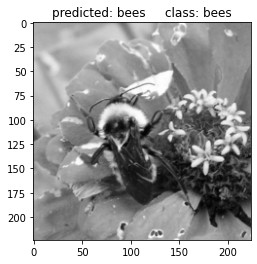

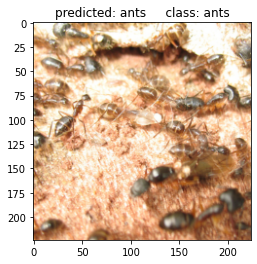

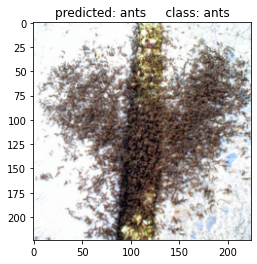

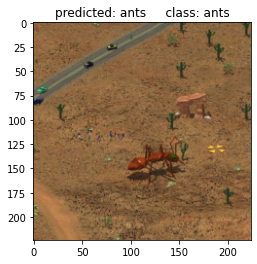

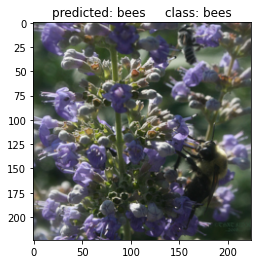

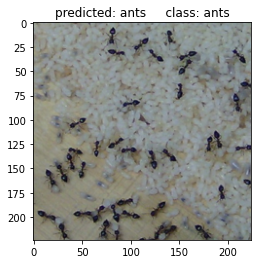

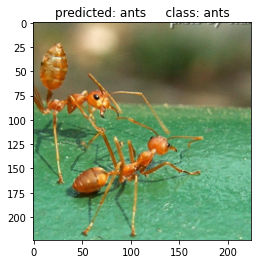

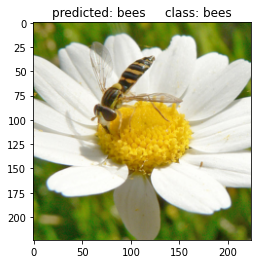

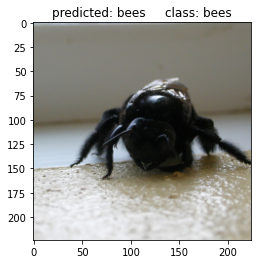

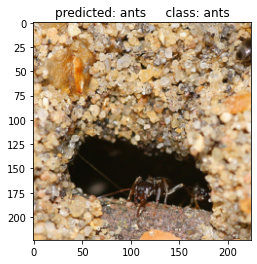

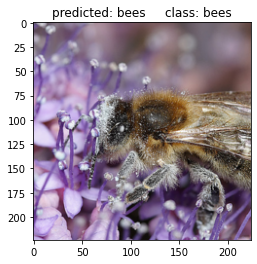

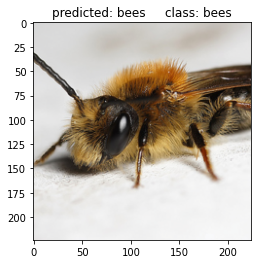

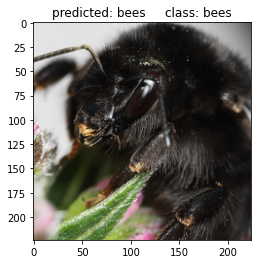

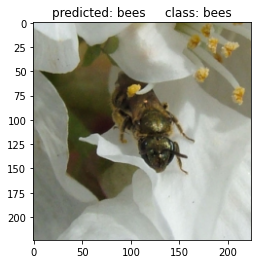

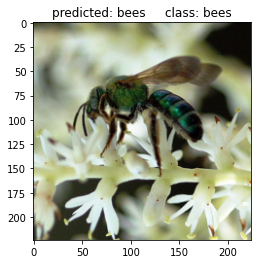

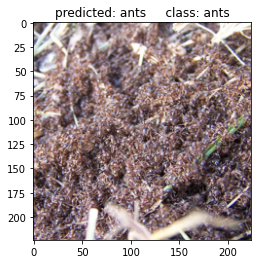

In [ ]:
visualize_model(model)

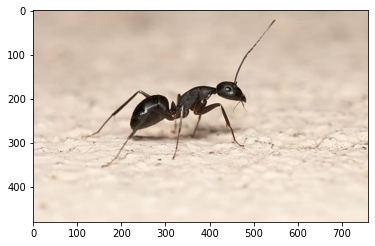

In [ ]:
image = io.imread('https://cdn.branchcms.com/7XlaZw139w-1201/images/ant-pest-image.v1.jpg')
plt.imshow(image);

In [ ]:
img = apply_transforms(image).clone().detach().requires_grad_(True).to(device)

In [ ]:
outputs = model(img)
preds = torch.max(outputs, 1)[1]

In [ ]:
print('predicted: ' + dataset_labels[preds])

predicted: ants


In [ ]:
batch_size = 1024 #large batch size so we test all the data
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
inputs,labels = next(iter(dataloaders['valid']))
inputs = inputs.to(device)
labels = labels.detach().cpu().numpy()

In [ ]:
outputs = model(inputs)
preds = torch.max(outputs, 1)[1].detach().cpu().numpy()

In [ ]:
cm = confusion_matrix(preds.reshape(-1),labels)

Confusion Matrix : 


In [ ]:
print("Confusion Matrix : ")
cm

Confusion Matrix : 


array([[67,  4],
       [ 3, 79]])